<font color="#483D8B">
<h1  align="center">Matrix and Graph Data Types</h1>
<h2  align="center">Lab 4</h2>
<h4 align="center">
INET4710 Spring 2018<br>
Submitted by (your name here)</h4>
</font>

---------------

### Lab Objectives

* Write scalable operations using the following data types:
    - Vector
    - Matrix
        - Distributed Matrix
    - Graph


* Code matrix operations, graph operations, and data type conversions in:
    - scipy
    - pyspark


* Learn a few useful basic machine learning techniques
    - Matrix
        - SVD (Singular Value Decomposition)
        - SGD (Stochastic Gradient Descent)
    - Graph
        - Find Shortest Distance

Instructions: <br>
** For this lab, please submit the Jupyter notebook and include answers to the 10 questions. **

Notes: <br>
- ** scipy.linalg vs numpy.linalg ** <br>
from https://docs.scipy.org/doc/scipy/reference/tutorial/linalg <br>
scipy.linalg contains all the functions in numpy.linalg. plus some other more advanced ones not contained in numpy.linalg. (For this reason, please use scipy.linalg) 


- ** matrix subclass of ndarray ** <br>
from http://currents.soest.hawaii.edu/ocn_data_analysis/numpy_tutorial.html <br>
Numpy includes a matrix subclass of the ndarray base class. Please ignore it. It is not commonly used, it provides only small advantages and only under highly restricted circumstances, and elsewhere it can cause hard-to-diagnose problems. (Please use 2D numpy.ndarray objects instead) 


- ** scipy documentation ** <br>
https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_SciPy_Cheat_Sheet_Linear_Algebra.pdf <br>
https://docs.scipy.org/doc/scipy/reference/


-------------------------------------

###  scipy matrix

- sparse 
- dense 

from https://scipy.github.io/old-wiki/pages/SciPyPackages/Sparse.html <br>
A sparse matrix is a two-dimensional matrix with a large number of zero values. In contrast, a matrix where many or most entries are non-zero is said to be dense. There are no strict rules for what constitutes a sparse matrix, so we'll say that a matrix is sparse if there is some benefit to exploiting its sparsity. Additionally, there are a variety of sparse matrix formats which are designed to exploit different sparsity patterns (the structure of non-zero values in a sparse matrix) and different methods for accessing and manipulating matrix entries.

Sparsity Patterns:
- Diagonal
- Block
- Unstructured
- Sensitivity of pattern to ordering, and use of reordering for locality (e.g. direct solvers)

Each sparse format has certain advantages and disadvantages. For instance, adding new non-zero entries to a lil_matrix is fast, however changing the sparsity pattern of a csr_matrix requires a significant amount of work. On the other hand, operations such as matrix-vector multiplication and matrix-matrix arithmetic are much faster with csr_matrix than lil_matrix. A good strategy is to construct matrices using one format and then convert them to another that is better suited for efficient computation.

The scipy.sparse module provides data structures for 2D sparse matrices. There are seven sparse matrix types:

- csc_matrix: Compressed Sparse Column format
- csr_matrix: Compressed Sparse Row format
- bsr_matrix: Block Sparse Row format
- lil_matrix: List of Lists format
- dok_matrix: Dictionary of Keys format
- coo_matrix: COOrdinate format (aka IJV, triplet format)
- dia_matrix: DIAgonal format

In [3]:
# sparse spark vector
# demonstrate sample code to create scipy sparse vectors
import numpy as np
import scipy.sparse# sparse spark vector

# code adapted from https://stackoverflow.com/questions/2540059/scipy-sparse-arrays
n = 10
# create a 50% sparse vector of random numbers
x = (np.random.rand(n) * 2).astype(int).astype(float) 
print( type(x) )

# convert numpy vector to csr vector
x_csr = scipy.sparse.csr_matrix(x)
# convert numpy vector to dok vector
x_dok = scipy.sparse.dok_matrix(x.reshape(x_csr.shape))

print ( repr(x_csr) )

<class 'numpy.ndarray'>
<1x10 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>


In [82]:
# sparse spark vector
# performance comparison of sparse data structures
import scipy.sparse
import numpy as np
import timeit

# create a 50% sparse vector of random numbers
def mm_numpy():
    n = 1000
    x = (np.random.rand(n) * 2).astype(int).astype(float) 
    np.dot(x, x)

def mm_dict():
    n = 1000
    x = (np.random.rand(n) * 2).astype(int).astype(float) 
    x_csr = scipy.sparse.csr_matrix(x)
    x_dok = scipy.sparse.dok_matrix(x.reshape(x_csr.shape))
    x_dok * x_dok.T

def mm_csrmult():
    n = 1000
    x = (np.random.rand(n) * 2).astype(int).astype(float) 
    x_csr = scipy.sparse.csr_matrix(x)
    x_csr.multiply(x_csr).sum()
    
def mm_csrdot():
    n = 1000
    x = (np.random.rand(n) * 2).astype(int).astype(float) 
    x_csr = scipy.sparse.csr_matrix(x)
    x_csr * x_csr.T
    
print ("matrix multiplication: numpy")
t = timeit.timeit("mm_numpy()", setup='import numpy as np; from __main__ import mm_numpy', number=50)
print ( t )

print ("\nmatrix multiplication: dictionary of keys")
t = timeit.timeit('mm_dict()', setup='import numpy as np; from __main__ import mm_dict', number=50)
print ( t )

print ("\nmatrix multiplication: compressed sparse row multiply sum")
t = timeit.timeit("mm_csrmult()", setup='import numpy as np; from __main__ import mm_csrmult', number=50)
print ( t )

print ("\nmatrix multiplication: compressed sparse row transpose")
t = timeit.timeit("mm_csrdot()", setup='import numpy as np; from __main__ import mm_csrdot', number=50)
print ( t )

matrix multiplication: numpy
0.0016523836402484449

matrix multiplication: dictionary of keys
0.36879054901055497

matrix multiplication: compressed sparse row multiply sum
0.022766459691411

matrix multiplication: compressed sparse row transpose
0.023723507979411806


** Question 1. Modify the sparse vector performance code above to create two-dimensional matrices and to loop through a few iterations of different sized matrices. Plot the result (matrix size or iteration number vs. time). **

In [5]:
# sparse spark vector
# performance comparison of sparse data structures
import scipy.sparse
import numpy as np
import timeit

# loop five times
perf_numpy = np.zeros((5, 2))
perf_dict = np.zeros((5, 2))
perf_csrmult = np.zeros((5, 2))
perf_csrdot = np.zeros((5, 2))


# create a 50% sparse vector of random numbers
def mm_numpy(i):
    n = 100 * i
    x = (np.random.rand(n ** 2) * 2).astype(int).astype(float).reshape((n, n))
    np.dot(x, x)


def mm_dict(i):
    n = 100 * i
    x = (np.random.rand(n ** 2) * 2).astype(int).astype(float).reshape((n, n))
    x_csr = scipy.sparse.csr_matrix(x)
    x_dok = scipy.sparse.dok_matrix(x.reshape(x_csr.shape))
    x_dok * x_dok.T


def mm_csrmult(i):
    n = 100 * i
    x = (np.random.rand(n ** 2) * 2).astype(int).astype(float).reshape((n, n))
    x_csr = scipy.sparse.csr_matrix(x)
    x_csr.multiply(x_csr).sum()


def mm_csrdot(i):
    n = 100 * i
    x = (np.random.rand(n ** 2) * 2).astype(int).astype(float).reshape((n, n))
    x_csr = scipy.sparse.csr_matrix(x)
    x_csr * x_csr.T


# matrix multiplication: numpy
for i in range(1, 6):
    t = timeit.timeit("mm_numpy(i)", setup='import numpy as np; from __main__ import mm_numpy; i = (' + str(i) + ')',
                      number=50)
    perf_numpy[i - 1][0] = i
    perf_numpy[i - 1, 1] = t

# matrix multiplication: dictionary of keys
for i in range(1, 6):
    t = timeit.timeit('mm_dict(i)', setup='import numpy as np; from __main__ import mm_dict; i = (' + str(i) + ')',
                      number=50)
    perf_dict[i - 1][0] = i
    perf_dict[i - 1, 1] = t

# matrix multiplication: compressed sparse row multiply sum
for i in range(1, 6):
    t = timeit.timeit("mm_csrmult(i)",
                      setup='import numpy as np; from __main__ import mm_csrmult; i = (' + str(i) + ')', number=50)
    perf_csrmult[i - 1][0] = i
    perf_csrmult[i - 1, 1] = t

# matrix multiplication: compressed sparse row transpose
for i in range(1, 6):
    t = timeit.timeit("mm_csrdot(i)", setup='import numpy as np; from __main__ import mm_csrdot; i = (' + str(i) + ')',
                      number=50)
    perf_csrdot[i - 1][0] = i
    perf_csrdot[i - 1, 1] = t


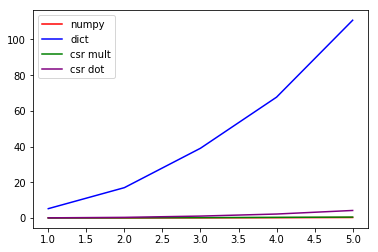

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# plt.plot(perf[:,0],perf[:,1])
# plt.show()

plt.plot(perf_numpy[:,0], perf_numpy[:,1], color='red', label='numpy')
plt.plot( perf_dict[:,0], perf_dict[:,1],  color='blue', label='dict')
plt.plot( perf_csrmult[:,0], perf_csrmult[:,1],  color='green', label='csr mult')
plt.plot( perf_csrdot[:,0],  perf_csrdot[:,1],   color='purple', label='csr dot')
plt.legend()
plt.show()

** Question 2. Convert matrix A to CSR format and solve (A A^T) x = b for x.
Output the first 10 elements of x. **

In [6]:
# from https://scipy.github.io/old-wiki/pages/Additional_Documentation/New_SciPy_Tutorial.html
from scipy import sparse
import scipy.sparse.linalg.dsolve as linsolve
from numpy import random, linalg

# Construct a 1000x1000 lil_matrix
A = sparse.lil_matrix((1000, 1000))
A[0, :100] = random.rand(100)
A[1, 100:200] = A[0, :100]
A.setdiag(random.rand(1000))

random.seed(1)
b = random.rand(1000)

A = A.tocsr()  # TODO: it already fulfill question before I do anything...?
x = linsolve.spsolve(A * A.T, b)
print(x[0:9])


[  15158.53771209  -24853.65199975  -16278.15346026 -294119.00377333
  -19696.02144414  -16018.57082919  -20839.67298855   -8617.9346644
  -50139.75641322]


** Question 3. matrix conversion of numpy to/from scipy. 
Write code in the cell below to do what the comments describe. **

In [7]:
# matrix conversion of numpy to/from scipy 
# from https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.coo_matrix.tocsr.html
from numpy import array
from scipy.sparse import coo_matrix

# construct a coo matrix
row  = array([0,0,1,3,1,0,0])
col  = array([0,2,1,3,1,0,0])
data = array([1,2,3,4,5,6,7])
A = coo_matrix( (data,(row,col)), shape=(4,4))  # TODO: what should I need to do???

# output python type and contents of A
print ("A - coo matrix format")
print (type(A))
print (A)

# question 3 - write code to answer the following:

# 1. convert A from coo to csr
A = A.tocsr() # TODO: it already finished?

# output python type and contents of A in sorted order
# note: CSR column indices are not necessarily sorted
print ("\nA - csr matrix format")
print (type(A))
print (A.sorted_indices())

# 2. convert A from csr to dense
A = A.todense()

# output python type and contents of A
print ("\nA - dense matrix format")
print (type(A))
print (A)
       
# 3. convert dense matrix to ndarray
# see https://stackoverflow.com/questions/5183533/how-to-make-list-from-numpy-matrix-in-python
print ("\nA - ndarray format")
# A = A.ravel().tolist
A = array(A)
print("fix code to make ndarray of A: ", type(A))

# output python type and contents of A
print (type(A))
print (" ")
print (A)



A - coo matrix format
<class 'scipy.sparse.coo.coo_matrix'>
  (0, 0)	1
  (0, 2)	2
  (1, 1)	3
  (3, 3)	4
  (1, 1)	5
  (0, 0)	6
  (0, 0)	7

A - csr matrix format
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 0)	14
  (0, 2)	2
  (1, 1)	8
  (3, 3)	4

A - dense matrix format
<class 'numpy.matrixlib.defmatrix.matrix'>
[[14  0  2  0]
 [ 0  8  0  0]
 [ 0  0  0  0]
 [ 0  0  0  4]]

A - ndarray format
fix code to make ndarray of A:  <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
 
[[14  0  2  0]
 [ 0  8  0  0]
 [ 0  0  0  0]
 [ 0  0  0  4]]


-------------------------------------

###  pyspark local vector and local matrix

- sparse vector
- dense vector
- sparse matrix 
- dense matrix (use with caution - watch big data sizes and performance)

<br>
** Local Vector: ** <br>
Generally use the following local vector data types in pyspark 2:
- Dense vectors (local):
    - numpy ndarray, scipy 1D matrix, python list
    - pyspark ml DenseVector
- Sparse vectors (local):
    - scipy 1D sparse matrix
    - pyspark ml SparseVector


Both dense vector and sparse vector are homogeneous and can only have numeric data

pyspark ml machine learning models also use distributed vectors (and matrices). The distributed structures are introduced later in this lab. Distributed matrices are accessed through the pyspark DataFrame data type, built on top of RDDs.


adapted from https://apache.googlesource.com/spark/+/branch-1.1/docs/mllib-data-types.md <br>
A pyspark local vector has integer-typed and 0-based indices and double-typed values, stored on a single machine. The ml module supports two types of local vectors: dense and sparse. A dense vector is backed by a double array representing its entry values, while a sparse vector is backed by two parallel arrays: indices and values. 

For example, a vector (1.0, 0.0, 3.0) can be represented in dense format as [1.0, 0.0, 3.0] or in sparse format as (3, [0, 2], [1.0, 3.0]), where 3 is the size of the vector.

The base class of local vectors is Vector, and we provide two implementations: DenseVector and SparseVector. We recommend using the factory methods implemented in Vectors to create local vectors.

DenseVector behaves similarly to a numpy.ndarray or python list, and generally these structures can be used interchangably in pyspark

<br>
** Local Matrix ** <br>
A local matrix has integer-typed row and column indices and double-typed values, stored on a single machine. pyspark ml module supports dense matrices, in which element values are stored in a single double array in column major.

-------------------------------------

###  pyspark data frame

from https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/ <br>
A DataFrame is a distributed collection of rows under named columns. <br>
In simple terms, it is similar to a table in relational database or an Excel sheet with Column headers. <br>
It also shares some common characteristics with RDD:

- Immutable in nature : 
    - We can create DataFrame / RDD once but can’t change it.
    - And we can transform a DataFrame / RDD  after applying transformations.
- Lazy Evaluations: Which means that a task is not executed until an action is performed.
- Distributed: RDD and DataFrame both are distributed in nature.

In [8]:
# set up pyspark environment

from pyspark.sql import SparkSession
 
# local[*]  Run Spark locally with as many worker threads 
#           as logical cores on your machine
# getOrCreate() Gets an existing SparkSession or, if there 
#           is no existing one, creates a new one based on the 
#           options set in this builder

spark = SparkSession \
     .builder \
     .master("local[*]") \
     .appName("lab4") \
     .getOrCreate()

sc = spark.sparkContext

In [9]:
# scipy sparse csr matrix -> pandas sparse data frame
# demonstrate example code
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

np.random.seed(1)  # reproduce same result
arr = np.random.random(size=(1000, 5))
arr[arr < .9] = 0
sp_arr = csr_matrix(arr)
sdf = pd.SparseDataFrame(sp_arr)
sdf.head(5)

,0,1,2,3,4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,0.968262,NaN,NaN,NaN


In [10]:
# pandas sparse data frame -> pyspark data frame
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)  # instance of SQLContext execution class?
spark_df = sqlContext.createDataFrame(sdf)

# output data types in pyspark data frame
print( spark_df )
spark_df.show(5)

DataFrame[0: double, 1: double, 2: double, 3: double, 4: double]


+---+------------------+---+---+---+
|  0|                 1|  2|  3|  4|
+---+------------------+---+---+---+
|NaN|               NaN|NaN|NaN|NaN|
|NaN|               NaN|NaN|NaN|NaN|
|NaN|               NaN|NaN|NaN|NaN|
|NaN|               NaN|NaN|NaN|NaN|
|NaN|0.9682615757193975|NaN|NaN|NaN|
+---+------------------+---+---+---+
only showing top 5 rows



** Question 4. Starting with the ndarray below: **
1. ** Convert from the numpy ndarray to a pandas data frame **
2. ** Label the columns in the pandas data frame "random_sample1" and "random_sample2" **
3. ** Print the pyspark data frame schema **
4. ** Output the first 10 lines in the pyspark data frame **

In [11]:
# lab exercise: convert numpy array to pyspark data frame 
import pandas as pd
import numpy as np

nparr = np.random.random(size=(1000, 2))
nparr[nparr < .9] = 0

# step1: convert the numpy ndarray to a pandas data frame
pdf = pd.DataFrame(nparr)
# step2: label the feature (i.e., assign a name to the column) in the pandas data frame
pdf.columns = ['random_sample1','random_sample2']

# step3: convert the pandas data frame to a pyspark data frame
spark_df = sqlContext.createDataFrame(pdf)

# label the feature (i.e., assign a name to the column) in the pyspark data frame
spark_df.printSchema()

# step4: output the first 10 rows in the pyspark data frame
spark_df.show(10)

root
 |-- random_sample1: double (nullable = true)
 |-- random_sample2: double (nullable = true)

+--------------+------------------+
|random_sample1|    random_sample2|
+--------------+------------------+
|           0.0|               0.0|
|           0.0|0.9822712283503278|
|           0.0|               0.0|
|           0.0|               0.0|
|           0.0|               0.0|
|           0.0|               0.0|
|           0.0|               0.0|
|           0.0|0.9720306709820733|
|           0.0|               0.0|
|           0.0|               0.0|
+--------------+------------------+
only showing top 10 rows



In [12]:
# pyspark sparse vector -> numpy dense vector
from pyspark.ml.linalg import Vectors
sparseVector = Vectors.sparse(10, [1, 3], [3.0, 4.5])
denseVector = sparseVector.toArray()
print ( type(denseVector))

# Why didn't we convert from a pyspark sparse vector -> spark dense vector
# https://forums.databricks.com/questions/8895/converting-dataframe-sparse-vector-column-to-dense.html

<class 'numpy.ndarray'>


In [13]:
# example pyspark data frame contructed from sparse and dense vectors
# https://spark.apache.org/docs/2.2.0/ml-statistics.html
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

print(" ")
r2 = Correlation.corr(df, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Pearson correlation matrix:
DenseMatrix([[ 1.        ,  0.05564149,         nan,  0.40047142],
             [ 0.05564149,  1.        ,         nan,  0.91359586],
             [        nan,         nan,  1.        ,         nan],
             [ 0.40047142,  0.91359586,         nan,  1.        ]])
 


Spearman correlation matrix:
DenseMatrix([[ 1.        ,  0.10540926,         nan,  0.4       ],
             [ 0.10540926,  1.        ,         nan,  0.9486833 ],
             [        nan,         nan,  1.        ,         nan],
             [ 0.4       ,  0.9486833 ,         nan,  1.        ]])


-------------------------------------

###  pyspark distributed matrix operations

In Spark 2.0 you have to use correct local types:
-	pyspark.ml.linalg when working DataFrame based pyspark.ml API.
-	pyspark.mllib.linalg when working RDD based pyspark.mllib API.
These two namespaces are no longer compatible and require explicit conversions

<br>
An aside: <br>
https://home.apache.org/~pwendell/spark-nightly/spark-branch-2.0-docs/latest/ml-guide.html <br>
The MLlib RDD-based API is now in maintenance mode.

As of Spark 2.0, the RDD-based APIs in the spark.mllib package have entered maintenance mode. The primary Machine Learning API for Spark is now the DataFrame-based API in the spark.ml package.


In [14]:
#  scipy sparse matrix to pyspark RDD
# https://stackoverflow.com/questions/40645498/create-sparse-rdd-from-scipy-sparse-matrix/40648106#40648106
import numpy as np
import scipy.sparse as sps

# create a sparse matrix
row = np.array([0, 2, 2, 0, 1, 2])
col = np.array([0, 0, 1, 2, 2, 2])
data = np.array([1, 2, 3, 4, 5, 6]) 
sv = sps.csc_matrix((data, (row, col)), shape=(3, 3))
print ( type(sv) )
nparray = sv.toarray()
print (nparray)

print ( type(nparray) )

#read sv as RDD
sv_rdd = sc.parallelize(sv.toarray())  #convert scipy csc matrix to RDD

# memo:
# read something to spark service(context) is just use sc.xxx


print( type(sv_rdd) )
for x in sv_rdd.collect():
    print (x)
print ("For large RDD data sizes, better to output a sample number of rows from RDD")
for x in sv_rdd.take(2):
    print (x)

<class 'scipy.sparse.csc.csc_matrix'>
[[1 0 4]
 [0 0 5]
 [2 3 6]]
<class 'numpy.ndarray'>
<class 'pyspark.rdd.RDD'>
[1 0 4]
[0 0 5]
[2 3 6]
For large RDD data sizes, better to output a sample number of rows from RDD
[1 0 4]
[0 0 5]


** Question 5. Why was it necessary to execute collect() before printing each array element? ** <br><br>
from https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html <br>
** At a high level, every Spark application consists of a driver program that runs the user’s main function and executes various parallel operations on a cluster. The main abstraction Spark provides is a resilient distributed dataset (RDD), which is a collection of elements partitioned across the nodes of the cluster that can be operated on in parallel. **

** collect() collesces the data from all the cluster nodes and transfers the data back to the node executing the driver program. **

While running spark in distributed RDD and showing output in a certain computer's standard output, we need to collect data from all the PC to get data we want to see.

In [15]:
# pyspark multiplication using RDD BlockMatrix 
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix

# Create an RDD of sub-matrix blocks.
blocks = sc.parallelize([((0, 0), Matrices.dense(3, 2, [1, 2, 3, 4, 5, 6])), 
                         ((1, 0), Matrices.dense(3, 2, [7, 8, 9, 10, 11, 12]))])

# Create a BlockMatrix from an RDD of sub-matrix blocks.
matA = BlockMatrix(blocks, 3, 2)
matB = BlockMatrix(blocks, 3, 2).transpose()

# colsPerBlock of this matrix must equal the rowsPerBlock of other
amultb = matA.multiply(matB)
adotb = amultb.blocks.collect()
print( type(adotb) )
print( adotb )

# note: an improvement over this method is given in:
# https://labs.yodas.com/large-scale-matrix-multiplication-with-pyspark-or-how-to-match-two-large-datasets-of-company-1be4b1b2871e
# which is much more involved than the BlockMatrix matrix multiplication

<class 'list'>
[((0, 0), DenseMatrix(3, 3, [17.0, 22.0, 27.0, 22.0, 29.0, 36.0, 27.0, 36.0, 45.0], 0)), ((1, 0), DenseMatrix(3, 3, [47.0, 52.0, 57.0, 64.0, 71.0, 78.0, 81.0, 90.0, 99.0], 0)), ((0, 1), DenseMatrix(3, 3, [47.0, 64.0, 81.0, 52.0, 71.0, 90.0, 57.0, 78.0, 99.0], 0)), ((1, 1), DenseMatrix(3, 3, [149.0, 166.0, 183.0, 166.0, 185.0, 204.0, 183.0, 204.0, 225.0], 0))]


** Question 6. Write code in the cell below to execute a pyspark BlockMatrix transpose operation **

In [16]:
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix

# Create an RDD of sub-matrix blocks.
blocks = sc.parallelize([((0, 0), Matrices.dense(3, 2, [1, 2, 3, 4, 5, 6])), 
                         ((1, 0), Matrices.dense(3, 2, [7, 8, 9, 10, 11, 12]))])

# Create a BlockMatrix from an RDD of sub-matrix blocks.
matA = BlockMatrix(blocks, 3, 2)

atranspose = matA.transpose()
aT = atranspose.blocks.collect()
print( type(aT) )
print( aT )

<class 'list'>
[((0, 0), DenseMatrix(2, 3, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0], 1)), ((0, 1), DenseMatrix(2, 3, [7.0, 8.0, 9.0, 10.0, 11.0, 12.0], 1))]


** Question 7. Write code in the cell below to execute a pyspark SVD operation **

In [17]:
# SVD (Singular Value Decomposition)
# from https://spark.apache.org/docs/2.2.0/mllib-dimensionality-reduction.html
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

rows = sc.parallelize([
    Vectors.sparse(5, {1: 1.0, 3: 7.0}),
    Vectors.dense(2.0, 0.0, 3.0, 4.0, 5.0),
    Vectors.dense(4.0, 0.0, 0.0, 6.0, 7.0)
])

mat = RowMatrix(rows)

# Compute the top 5 singular values and corresponding singular vectors.
svd = mat.computeSVD(5, computeU=True)
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V = svd.V       # The V factor is a local dense matrix.

print("singular vector")
print(s)
print("\nV factor")
print(V)

print("\nU factor")
rowsRDD = U.rows
Umatrix = rowsRDD.collect()
print(Umatrix)

singular vector
[13.0292755356,5.36857873345,2.53304982188,6.32316604921e-08,2.02269345571e-08]

V factor
DenseMatrix([[-0.31278534,  0.31167136,  0.30366911,  0.8409913 , -0.07446478],
             [-0.02980145, -0.17133211, -0.02226069,  0.14664984,  0.97352733],
             [-0.12207248,  0.15256471, -0.95070998,  0.23828799, -0.03452092],
             [-0.71847899, -0.68096285, -0.0172245 , -0.02094998, -0.13907533],
             [-0.60841059,  0.62170723,  0.05606596, -0.46260933,  0.16175873]])

U factor


[DenseVector([-0.3883, -0.9198, -0.0564, 0.0, 0.0]), DenseVector([-0.5302, 0.273, -0.8027, 0.0, 0.0]), DenseVector([-0.7538, 0.2818, 0.5937, 0.0, 0.0])]


** Question 8. Complete the pyspark sql code below. **

In [18]:
# pyspark sql
# from https://docs.databricks.com/spark/latest/dataframes-datasets/introduction-to-dataframes-python.html
from pyspark.sql import *

# Create Example Data - Departments and Employees

# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@berkeley.edu', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@stanford.edu', 120000)
employee3 = Employee('matei', None, 'no-reply@waterloo.edu', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@berkeley.edu', 160000)

# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee1, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])

print("department1")
print (department1)
print("employee2")
print (employee2)
print("email")
print (departmentWithEmployees1.employees[0].email)

departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = sqlContext.createDataFrame(departmentsWithEmployeesSeq1)
print("df1")
display(df1)

departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = sqlContext.createDataFrame(departmentsWithEmployeesSeq2)
print("df2")
display(df2)

# 1. write code to output the first row of df1
print("first")
print(df1.first())

# 2. write code to calculate the union of df1 and df2
print("union")
unionDF = df1.unionAll(df2)
display(unionDF)

# 3. write code to select the department column from df1
print("department column")
df1.select("department").show()

# 4. write code to output df1 sorted by department name (in ascending order)
print("orderBy")
d = df1.orderBy(["department"]).collect()
print(*d, sep = "\n")

# 5. write code to select employees.firstName
df1.select("employees.firstName").show()


department1
Row(id='123456', name='Computer Science')
employee2
Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)
email
no-reply@berkeley.edu
df1


DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

df2


DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

first
Row(department=Row(id='123456', name='Computer Science'), employees=[Row(firstName='michael', lastName='armbrust', email='no-reply@berkeley.edu', salary=100000), Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)])
union


DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

department column


+--------------------+
|          department|
+--------------------+
|[123456,Computer ...|
|[789012,Mechanica...|
+--------------------+

orderBy


Row(department=Row(id='123456', name='Computer Science'), employees=[Row(firstName='michael', lastName='armbrust', email='no-reply@berkeley.edu', salary=100000), Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)])
Row(department=Row(id='789012', name='Mechanical Engineering'), employees=[Row(firstName='matei', lastName=None, email='no-reply@waterloo.edu', salary=140000), Row(firstName=None, lastName='wendell', email='no-reply@berkeley.edu', salary=160000)])
+-------------------+
|          firstName|
+-------------------+
|[michael, xiangrui]|
|      [matei, null]|
+-------------------+



--------------------------

### graph

Calculate single source shortest distances in O(V+E) time for DAGs using Topological Sorting.

Initialize distances to all vertices as infinite and distance to source as 0, then find a topological sorting of the graph. Topological Sorting of a graph represents a linear ordering of the graph. Once a topological order is established, process each vertex in topological order. For every vertex processed, update distances of its adjacent using distance of current vertex.

How is the graph represented in the shortest path program?

The graph is represented using an adjacency list. Each node of adjacency list contains vertex number of the vertex to which edge connects. It also contains weight of the edge


In [103]:
# graph - find shortest distance
from collections import defaultdict


class Graph:
    def __init__(self,vertices):
        self.V = vertices
        self.graph = defaultdict(list)
        
    def addEdge(self,u,v,w):
        self.graph[u].append((v,w))
 
    def topologicalSortUtil(self,v,visited,stack):
        visited[v] = True
 
        if v in self.graph.keys():
            for node,weight in self.graph[v]:
                if visited[node] == False:
                    self.topologicalSortUtil(node,visited,stack)
 
        stack.append(v)
 
    def shortestPath(self, s): 
        visited = [False]*self.V
        stack =[]

        for i in range(self.V):
            if visited[i] == False:
                self.topologicalSortUtil(s,visited,stack)
        
        dist = [float("Inf")] * (self.V)
        dist[s] = 0
 
        while stack:
            i = stack.pop()
            for node,weight in self.graph[i]:
                if dist[node] > dist[i] + weight:
                    dist[node] = dist[i] + weight
        
        for i in range(self.V):
            if dist[i] == float("Inf"):
                print(str(i) + " : Inf")
            else:
                print(str(i) + " : " + str(dist[i]))

g = Graph(6)
g.addEdge(0, 1, 5)
g.addEdge(0, 2, 3)
g.addEdge(1, 3, 6)
g.addEdge(1, 2, 2)
g.addEdge(2, 4, 4)
g.addEdge(2, 5, 2)
g.addEdge(2, 3, 7)
g.addEdge(3, 4, -1)
g.addEdge(4, 5, -2)
 
# source = 1
s = 1


** Question 9. Write code (using the python class above) to find the shortest path distances from vertex 1 to other nodes. **

In [104]:
# source = 1
s = 1
 
print ("Following are shortest distances from source %d " % s)
g.shortestPath(s)
        


Following are shortest distances from source 1 
0 : Inf
1 : 0
2 : 2
3 : 6
4 : 5
5 : 3


--------

ONLY FOR YOUR INTEREST. NO NEED TO DO ANYTHING FOR THE LAB HERE. ** WARNING: ADVANCED EXAMPLE ** <br>
If you are interested in seeing an application of the concepts in this lab, take a look at: <br>
https://blogs.msdn.microsoft.com/data_insights_global_practice/2017/02/16/scaling-up-scikit-learns-random-projection-using-apache-spark/

In [19]:
# MEMO: it seems almost already done when I downloaded this file from canvas, thus I just do just a few fix. :-??
# What's happened???